In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
#1)
claims=pd.read_csv('claims.csv').convert_dtypes()
cust = pd.read_csv('cust_demographics.csv').convert_dtypes()

In [4]:
#2)
claims.dtypes


claim_id                Int64
customer_id             Int64
incident_cause         string
claim_date             string
claim_area             string
police_report          string
claim_type             string
claim_amount           string
total_policy_claims     Int64
fraudulent             string
dtype: object

In [5]:
cust.dtypes

CUST_ID         Int64
gender         string
DateOfBirth    string
State          string
Contact        string
Segment        string
dtype: object

In [6]:
#3)
claims['claim_amount'] = claims['claim_amount'].str[1:].astype('float')

In [7]:
#4)
claims['Unreported']=pd.get_dummies(claims['police_report']).drop(['Yes','Unknown'],axis=1)

In [8]:
#5)
claims=claims.sort_values(by='claim_date',ascending=False)
claims.drop_duplicates(subset=['customer_id'],keep='first',inplace=True)

In [9]:
#6)
missing ={}
for i in claims:
    if pd.api.types.is_number(claims[i]):
        missing[i]= claims[i].median()
    else:
        missing[i]= claims[i].mode()[0]
claims=claims.fillna(missing)

In [10]:
#7)
cust['DateOfBirth'] = pd.to_datetime(cust['DateOfBirth'])
cust['Age']= dt.datetime.today().year- cust['DateOfBirth'].dt.year
cust['Age_group']= np.where(cust.Age<18,'Children',np.where(cust.Age<30,'Youth',np.where(cust.Age<60,'Adult','Senior')))

In [11]:
#8)
combined=cust.merge(claims,how='inner', left_on='CUST_ID',right_on='customer_id')
combined.groupby('Segment').mean()['claim_amount']

Segment
Gold        12144.940701
Platinum    11919.921053
Silver      11388.066474
Name: claim_amount, dtype: float64

In [12]:
#9)
claims['claim_date'] = pd.to_datetime(claims['claim_date'])
claims[claims['claim_date']< pd.to_datetime('10/1/2018')-dt.timedelta(days = 20)].groupby('incident_cause').sum()['claim_amount']

incident_cause
Crime                  672732.0
Driver error          3177590.0
Natural causes        1217691.5
Other causes          3574439.0
Other driver error    3240118.0
Name: claim_amount, dtype: float64

In [13]:
#10)
x=combined[(combined['Age_group']=='Adult')& (combined['State'].isin(['TX','DE','AK'])&(combined['incident_cause'].isin(['Driver error','Other driver error'])))]['CUST_ID'].count()
print(f'No. of adults from TX, DE and AK claimed insurance for driver related issues is {x}')

No. of adults from TX, DE and AK claimed insurance for driver related issues is 21


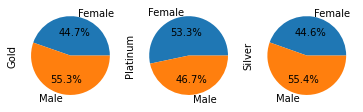

In [14]:
#11)
x= combined.groupby(by=['Segment','gender']).sum()['claim_amount'].reset_index()
x= x.pivot(index="Segment", columns= "gender", values= "claim_amount")
x=x.T
x.plot(kind='pie',subplots= True , legend=False,autopct='%1.1f%%')
plt.show()

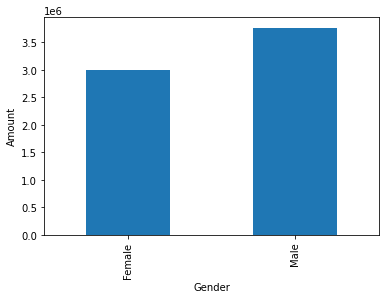

In [14]:
#12) 
x=combined[combined['incident_cause'].isin(['Driver error','Other driver error'])].groupby(by='gender').sum()['claim_amount']
x.plot(kind='bar')
plt.xlabel("Gender")
plt.ylabel("Amount")
plt.show()

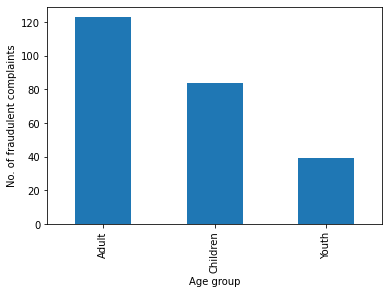

In [15]:
#13)
combined[combined['fraudulent']=='Yes'].groupby('Age_group').count()['CUST_ID'].plot(kind='bar')
plt.xlabel('Age group')
plt.ylabel('No. of fraudulent complaints')
plt.show()

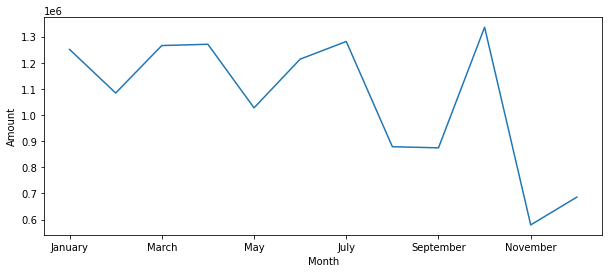

In [41]:
#14)
combined['claim_date']= pd.to_datetime(combined['claim_date']).sort_values()
monthly_trend=combined.groupby(by=[combined.claim_date.dt.strftime('%B')]).sum()['claim_amount'].to_frame()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_trend=monthly_trend.reindex(new_order, axis=0)
monthly_trend.plot(kind='line',legend=False,figsize=(10,4))
plt.xlabel('Month')
plt.ylabel('Amount')
plt.show()

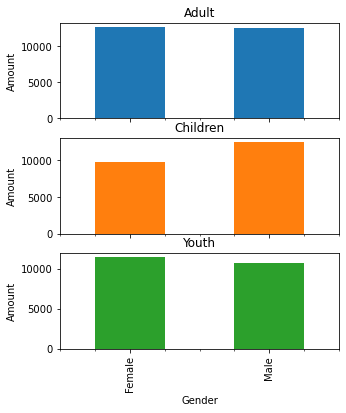

In [45]:
#15)
combined.groupby(by=['gender','Age_group']).mean()['claim_amount'].unstack(1).plot(kind='bar',xlabel='Gender',ylabel='Amount' ,subplots=True,legend=False,figsize=(5,6))
plt.show()

In [18]:
"""
16.  Is there any similarity in the amount claimed by males and females?

H0 = Avg_male = Avg_female
Ha = Avg_male <> Avg_female
Confidence level = 95 %
Alpha =  0.05
"""

f_amount = combined[combined['gender']=='Female']['claim_amount']
m_amount = combined[combined['gender']=='Male']['claim_amount']
print('Female average= ',f_amount.mean())
print('Female std.= ',f_amount.std())
print('Male average= ',m_amount.mean())
print('Male std.= ',m_amount.std())

Female average=  11502.906072106261
Female std.=  13361.972567964483
Male average=  12136.304900181489
Male std.=  13849.741417591147


In [19]:
test =stats.ttest_ind(m_amount,f_amount)
print('P value= ',test.pvalue)
print('T statistic= ',test.statistic)
print('Conclusion: We can not reject null hypothesis because the value of p is greater than 0.05 \nBuisness conclusion: The Average for Male and female customers is not equal.')

P value=  0.4452584916719806
T statistic=  0.7636244222217057
Conclusion: We can not reject null hypothesis because the value of p is greater than 0.05 
Buisness conclusion: The Average for Male and female customers is not equal.


In [20]:
"""
17. Is there any relationship between age category and segment?
H0= chi_square = 0
Ha = chi_square <>0
Confidence level = 95%
"""
crosst = pd.crosstab(combined.Age_group,combined.Segment)
chi=stats.chi2_contingency(crosst)
print('Chi value= ',chi[0])
print('P value= ',chi[1])
print('Conclusion: We can not reject null hypothesis because the value of p is greater than 0.05 \nBuisness conclusion: There is no relaionship between Age_group and segment ')

Chi value=  0.5886720425407048
P value=  0.9643141241774152
Conclusion: We can not reject null hypothesis because the value of p is greater than 0.05 
Buisness conclusion: There is no relaionship between Age_group and segment 


In [ ]:
"""
18.  The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.
H0: Amount in 2018< $10000
Ha: Amount in 2018> $10000

confidence level = 95%
"""

In [22]:
combined_year = combined.groupby(by='claim_date')['claim_amount'].sum().reset_index()
combined_year['year']=combined_year['claim_date'].apply(lambda x : pd.Timestamp.strftime(x ,format="%Y"))

In [23]:
after=combined_year.loc[combined_year.year=='2018','claim_amount']


In [24]:
t = stats.ttest_1samp(after,10000)
print('T-statistic= ',t.statistic)
print('Pvalue=',t.pvalue)
print('Conclusion: The pvalue for this test is less than 0.05, which meansn we can reject the null hypothesis\nBuisness conclusion: Current year amount is greater than amount in 2016-17 ')

T-statistic=  15.93033530043373
Pvalue= 6.938131263079584e-20
Conclusion: The pvalue for this test is less than 0.05, which meansn we can reject the null hypothesis
Buisness conclusion: Current year amount is greater than amount in 2016-17 


In [25]:
"""
19. Is there any difference between age groups and insurance claims?

"""

'\n19. Is there any difference between age groups and insurance claims?\n\n'

In [26]:
print(combined['Age_group'].value_counts())
a1=combined[combined['Age_group']=='Adult']['claim_amount']
a2=combined[combined['Age_group']=='Children']['claim_amount']
a3=combined[combined['Age_group']=='Youth']['claim_amount']
a4=combined[combined['Age_group']=='Adult']['claim_amount']

 # No records in senior

Adult       535
Children    335
Youth       208
Name: Age_group, dtype: int64


In [ ]:
"""
Hypothesis:
H0: There is no difference between age_groups and insurence claims
Ha: There is a relationship between age_groups and insurence claims
confidence level = 95%

"""

In [27]:
f = stats.f_oneway(a1,a2,a3)
print('F- statistic= ',f.statistic)
print('Pvalue',f.pvalue)
print('Conclusin: The pvalue is greater than 0.05 so we dont have enough evidence to reject null hypotheis\nBuisness conclusion: Because we can not reject null H0 we can not say that there is a relationship between age_groups and claims')

F- statistic=  1.564373056457609
Pvalue 0.20969505131797253
Conclusin: The pvalue is greater than 0.05 so we dont have enough evidence to reject null hypotheis
Buisness conclusion: Because we can not reject null H0 we can not say that there is a relationship between age_groups and claims


In [ ]:
"""20. Is there any relationship between total number of policy claims and the 
claimed amount?"""


In [29]:
combined['total_policy_claims'].unique()

<IntegerArray>
[1, 3, 6, 2, 4, 5, 7, 8]
Length: 8, dtype: Int64

In [ ]:
"""Hypothesis:
H0: pearson's r = 0
Ha: pearson's r <> 0

confidence level = 95%
"""

In [31]:
stats.pearsonr(combined.total_policy_claims, combined.claim_amount)


(-0.016200349545669672, 0.5951953931995123)

In [32]:
print('Conclussion: The pvalue for this test is greater than 0.5, so we can not reject the null hypothesis.\nBuisness conclusion: There is no relationship between the no. of policy claims and claim amount')

Conclussion: The pvalue for this test is greater than 0.5, so we can not reject the null hypothesis.
Buisness conclusion: There is no relationship between the no. of policy claims and claim amount
